# Exercise- 1: Image Acquisition and Color Sensing

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image from file
image = cv2.imread('/content/nature.png')

# Convert image to different color spaces
def convert_color_spaces(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image_rgb, image_hsv, image_yuv

# Display images in grid
def display_images(images, titles, cmap=None):
    plt.figure(figsize=(12, 8))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display histograms for each channel
def display_histograms(channels, titles):
    plt.figure(figsize=(12, 4))
    for i, (channel, title) in enumerate(zip(channels, titles)):
        plt.subplot(1, len(channels), i + 1)
        plt.hist(channel.ravel(), bins=256, color='gray', alpha=0.7)
        plt.title(f'Histogram of {title}')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
    plt.show()

# Main code
image_rgb, image_hsv, image_yuv = convert_color_spaces(image)

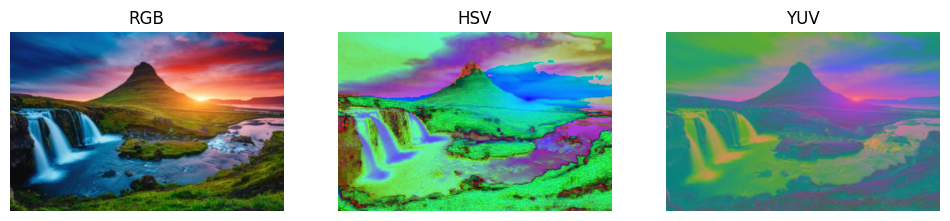

In [16]:
# Display original and transformed images
display_images([image_rgb, image_hsv, image_yuv], ['RGB', 'HSV', 'YUV'])

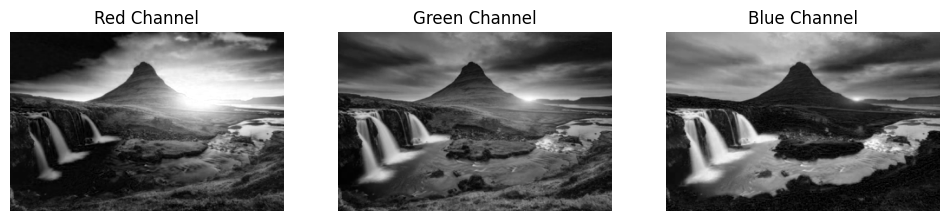

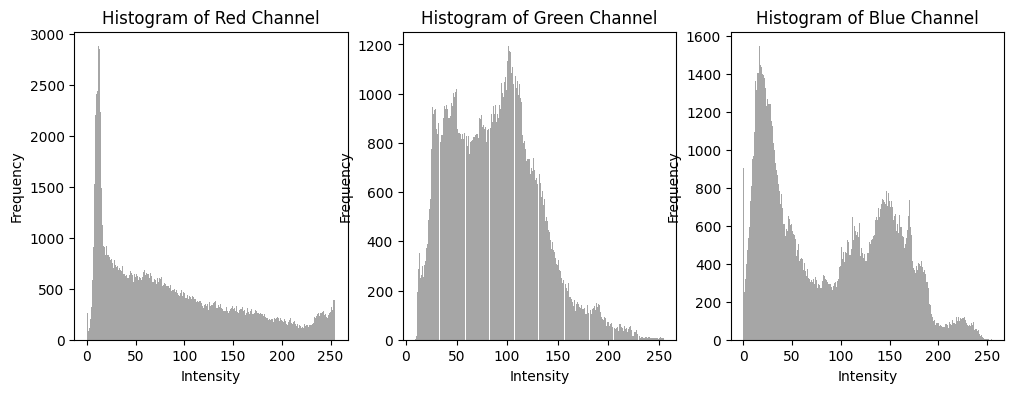

In [17]:
# Display individual channels for each color space
# RGB channels
display_images([image_rgb[:, :, 0], image_rgb[:, :, 1], image_rgb[:, :, 2]],
               ['Red Channel', 'Green Channel', 'Blue Channel'], cmap='gray')
display_histograms([image_rgb[:, :, 0], image_rgb[:, :, 1], image_rgb[:, :, 2]],
                   ['Red Channel', 'Green Channel', 'Blue Channel'])

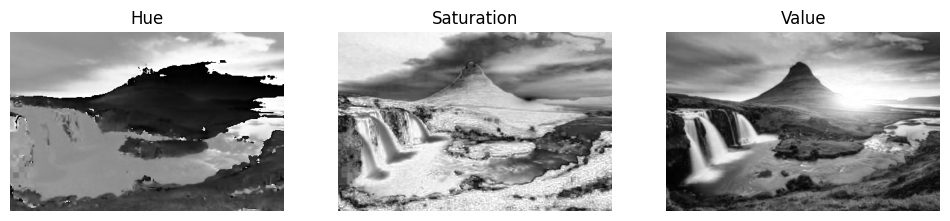

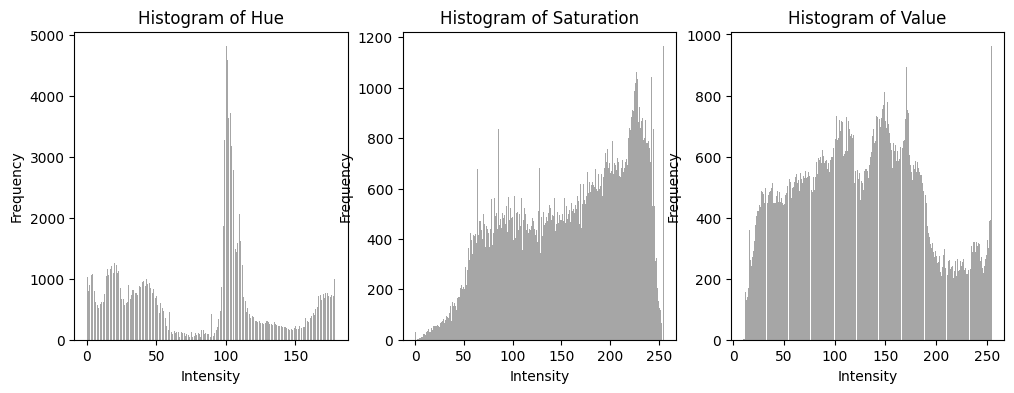

In [18]:
# HSV channels
display_images([image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]],
               ['Hue', 'Saturation', 'Value'], cmap='gray')
display_histograms([image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]],
                   ['Hue', 'Saturation', 'Value'])

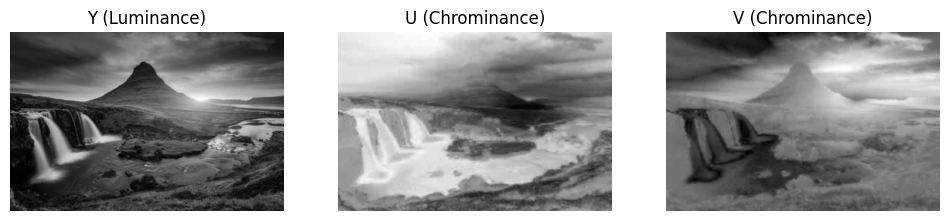

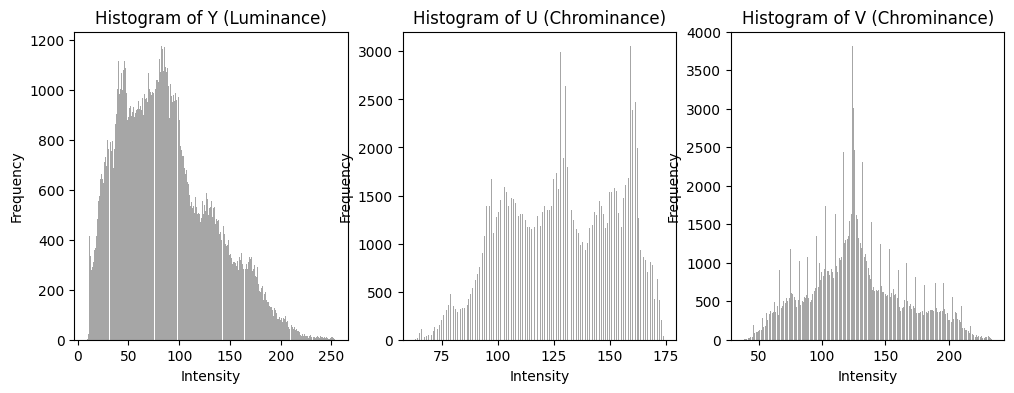

In [19]:
# YUV channels
display_images([image_yuv[:, :, 0], image_yuv[:, :, 1], image_yuv[:, :, 2]],
               ['Y (Luminance)', 'U (Chrominance)', 'V (Chrominance)'], cmap='gray')
display_histograms([image_yuv[:, :, 0], image_yuv[:, :, 1], image_yuv[:, :, 2]],
                   ['Y (Luminance)', 'U (Chrominance)', 'V (Chrominance)'])

- The image has been converted into RGB, HSV, and YUV color spaces.
- Individual channels for each color space (RGB, HSV, and YUV) are displayed, which helps to visually inspect the contributions of each channel.


The histograms shows:

- The distribution of colors in each RGB channel.
- The concentration of colors in the HSV color space, particularly the spike in - The Hue histogram, which often occurs in natural images with a dominant color.
The luminance and chrominance information in the YUV color space.

# Exercise - 2: Gaussian and Laplacian Pyramids

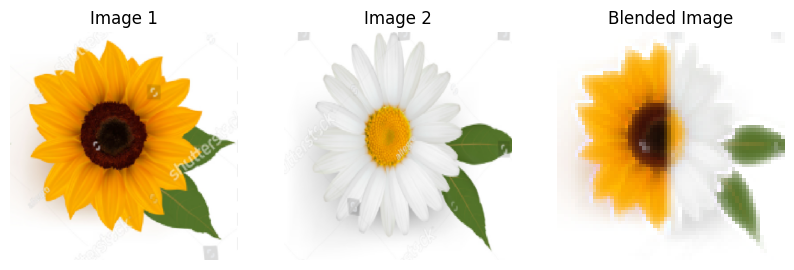

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the images (Replace with your paths)
image1 = cv2.imread('/content/sunflower.png')  # For example, a mountain image
image2 = cv2.imread('/content/daisy.png')  # For example, a sky image

# Define the target resolution for both images
target_resolution = (512, 512)  # You can adjust this to a preferred size

# Resize both images
# Resize both images using nearest-neighbor interpolation
image1 = cv2.resize(image1, target_resolution, interpolation=cv2.INTER_NEAREST)
image2 = cv2.resize(image2, target_resolution, interpolation=cv2.INTER_NEAREST)

# Convert images from BGR to RGB for visualization
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Function to build Gaussian Pyramid
def gaussian_pyramid(image, levels):
    gaussian_pyr = [image]
    for i in range(levels):
        image = cv2.pyrDown(image)
        gaussian_pyr.append(image)
    return gaussian_pyr

# Function to build Laplacian Pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_pyr = []
    for i in range(len(gaussian_pyr) - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=gaussian_pyr[i - 1].shape[:2])
        laplacian = cv2.subtract(gaussian_pyr[i - 1], expanded)
        laplacian_pyr.append(laplacian)
    laplacian_pyr.append(gaussian_pyr[-1])  # Last level in Laplacian pyramid
    laplacian_pyr.reverse()
    return laplacian_pyr

# Step 2: Build Gaussian and Laplacian Pyramids for both images
levels = 4  # Define the number of pyramid levels
gaussian_pyr_image1 = gaussian_pyramid(image1, levels)
gaussian_pyr_image2 = gaussian_pyramid(image2, levels)
laplacian_pyr_image1 = laplacian_pyramid(gaussian_pyr_image1)
laplacian_pyr_image2 = laplacian_pyramid(gaussian_pyr_image2)

# Step 3: Blend the Laplacian pyramids of both images
laplacian_pyr_blended = []
for lap1, lap2 in zip(laplacian_pyr_image1, laplacian_pyr_image2):
    rows, cols, ch = lap1.shape
    # Create a mask that splits the images down the middle
    laplacian_blend = np.hstack((lap1[:, :cols // 2], lap2[:, cols // 2:]))
    laplacian_pyr_blended.append(laplacian_blend)

# Step 4: Reconstruct the blended image from the blended Laplacian pyramid
blended_image = laplacian_pyr_blended[0]
for i in range(1, levels + 1):
    blended_image = cv2.pyrUp(blended_image)
    if blended_image.shape != laplacian_pyr_blended[i].shape:
        blended_image = cv2.resize(blended_image, (laplacian_pyr_blended[i].shape[1], laplacian_pyr_blended[i].shape[0]))
    blended_image = cv2.add(blended_image, laplacian_pyr_blended[i])

# Step 5: Apply sharpening filter to the blended image
sharpening_kernel = np.array([[ 0, -1,  0],
                               [-1,  5, -1],
                               [ 0, -1,  0]])

sharpened_image = cv2.filter2D(blended_image, -1, sharpening_kernel)

# Step 6: Display the results
# Original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1_rgb)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image2_rgb)
plt.title("Image 2")
plt.axis('off')

# Blended image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title("Blended Image")
plt.axis('off')
plt.show()


# Exercise - 3: Feature Detection and Matching

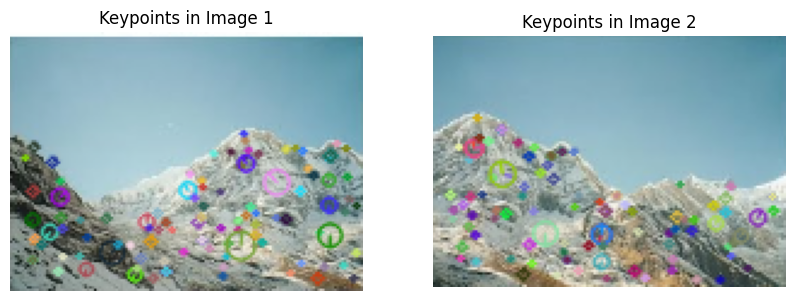

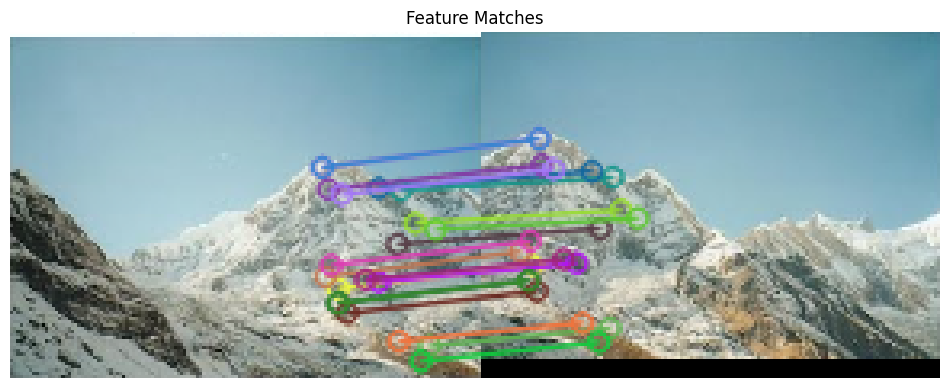

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load two images for feature matching
image1 = cv2.imread('/content/mountain.png')
image2 = cv2.imread('/content/mountain_1.png')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Draw keypoints for visualization
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_keypoints, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_keypoints, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 2")
plt.axis('off')
plt.show()

# Use Brute-Force matcher with L2 distance for SIFT
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches based on distance (lower distance indicates better match)
matches = sorted(matches, key=lambda x: x.distance)


# Draw top 20 matches (if using Brute-Force)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# If using FLANN-based matching with Lowe's ratio test
# matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches")
plt.axis('off')
plt.show()


# Eercise- 4: Edge Detection and Line Detection

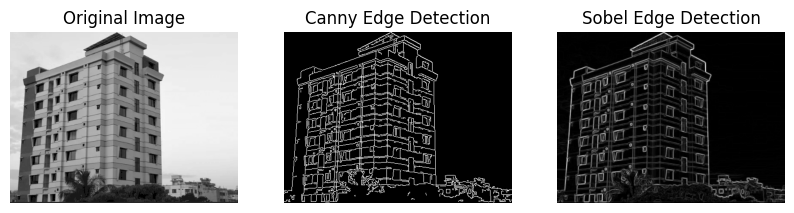

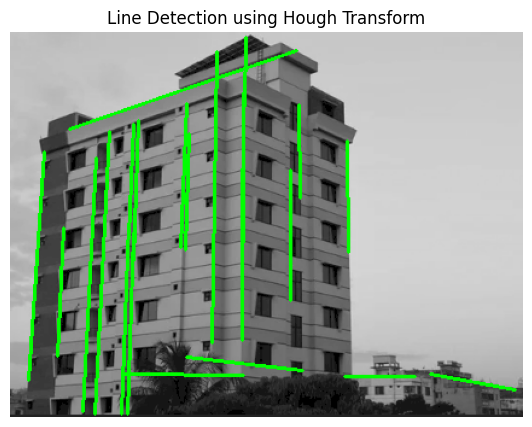

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/building_1.png', cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# 1. Edge Detection

# Apply Canny Edge Detection
edges_canny = cv2.Canny(image, 100, 200)

# Apply Sobel filtering
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)

# Display Canny and Sobel edge detection results
plt.subplot(1, 3, 2)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(sobel_edges, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis("off")

plt.show()

# 2. Line Detection using Hough Transform

# Convert edges to uint8 (required for HoughLinesP function)
edges_canny_uint8 = np.uint8(edges_canny)

# Use Hough Transform to detect lines in the Canny edges
lines = cv2.HoughLinesP(edges_canny_uint8, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw lines on it
line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the line detection result
plt.figure(figsize=(10, 5))
plt.imshow(line_image)
plt.title("Line Detection using Hough Transform")
plt.axis("off")
plt.show()


# Exercise- 5: Geometric Transformations and Affine Transformations

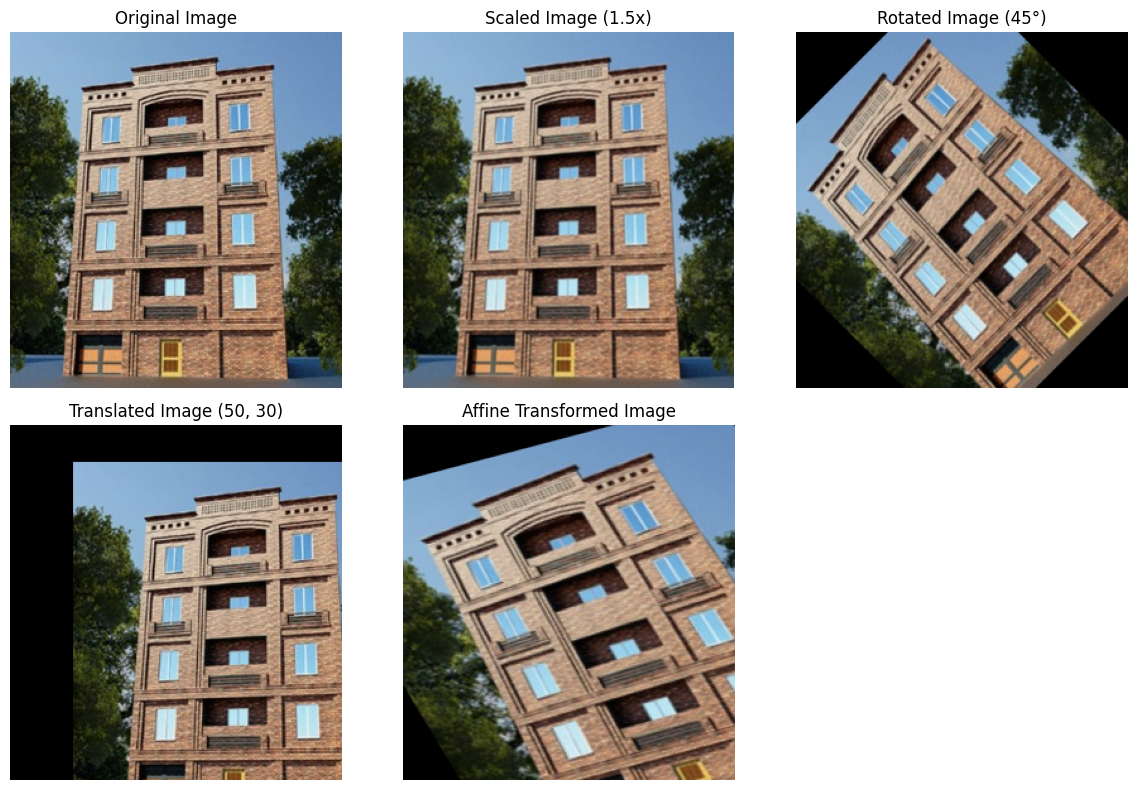

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/building.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization

# Display the original image
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# 1. Basic Transformations

# Scaling
scale_factor = 1.5  # Increase image size by 1.5x
scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
plt.subplot(2, 3, 2)
plt.imshow(scaled_image)
plt.title("Scaled Image (1.5x)")
plt.axis("off")

# Rotation
angle = 45  # Rotate image by 45 degrees
(h, w) = image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
plt.subplot(2, 3, 3)
plt.imshow(rotated_image)
plt.title("Rotated Image (45°)")
plt.axis("off")

# Translation
tx, ty = 50, 30  # Translate image by (50, 30) pixels
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
translated_image = cv2.warpAffine(image, translation_matrix, (w, h))
plt.subplot(2, 3, 4)
plt.imshow(translated_image)
plt.title("Translated Image (50, 30)")
plt.axis("off")

# 2. Affine Transformation

# Define three points for affine transformation
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

# Calculate affine transformation matrix and apply it
affine_matrix = cv2.getAffineTransform(pts1, pts2)
affine_transformed_image = cv2.warpAffine(image, affine_matrix, (w, h))

# Display Affine Transformed Image
plt.subplot(2, 3, 5)
plt.imshow(affine_transformed_image)
plt.title("Affine Transformed Image")
plt.axis("off")

# Show all transformations
plt.tight_layout()
plt.show()


# Exercise - 6: RANSAC and Projective Transformations

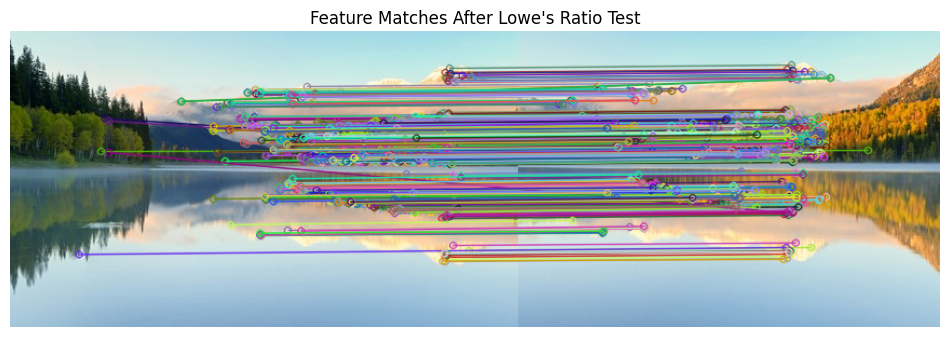

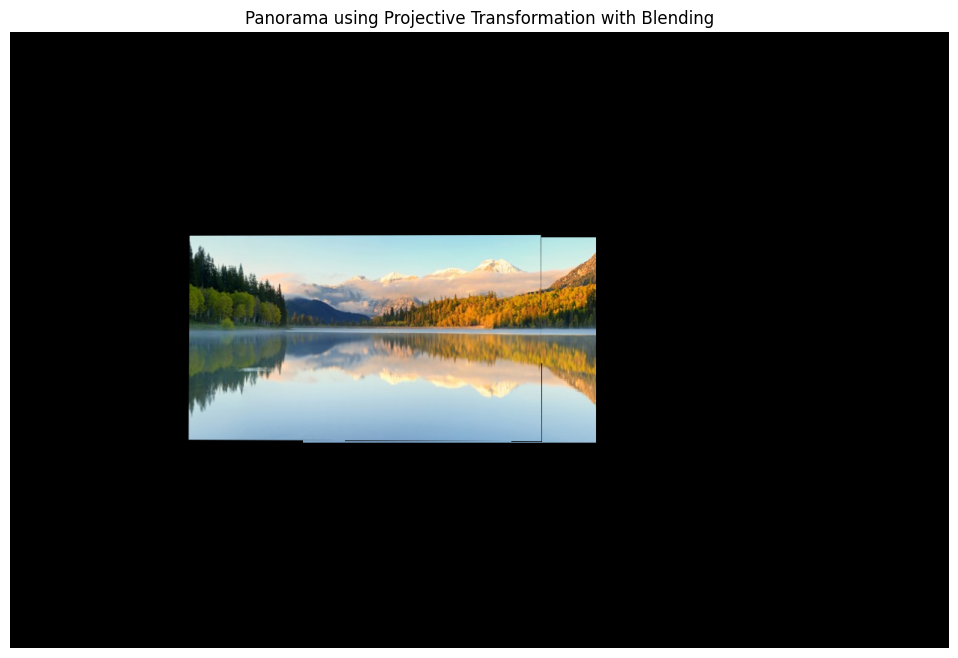

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images
image1 = cv2.imread('/content/1.jpg')
image2 = cv2.imread('/content/2.jpg')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# 1. Feature Detection and Matching

# Initialize ORB detector
orb = cv2.ORB_create(5000)

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Use BFMatcher with Lowe's ratio test to find good matches
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

# Draw good matches for visualization (optional)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches After Lowe's Ratio Test")
plt.axis("off")
plt.show()

# 2. Homography Estimation with RANSAC using good matches

# Extract location of good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute the homography matrix with RANSAC
homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 3. Projective Transformation for Panorama Creation

# Get dimensions of both images to create a large canvas for the panorama
height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

# Define a larger canvas size to avoid clipping
canvas_width = width1 + 2 * width2
canvas_height = height1 + 2 * height2

# Apply translation to the homography matrix to account for canvas shift
translation_matrix = np.array([[1, 0, width2], [0, 1, height2], [0, 0, 1]])
adjusted_homography = translation_matrix @ homography_matrix

# Warp the first image onto the large canvas
warped_image = cv2.warpPerspective(image1, adjusted_homography, (canvas_width, canvas_height))

# Create a mask for image2 for blending
mask_image2 = np.zeros_like(warped_image)
mask_image2[height2:height2+height2, width2:width2+width2] = image2

# Blend the warped_image and image2 using max function to avoid harsh edges
panorama = np.where(warped_image > 0, warped_image, mask_image2)

# Display the resulting panorama
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Panorama using Projective Transformation with Blending")
plt.axis("off")
plt.show()


# Exercise- 7: Optical Flow Estimation

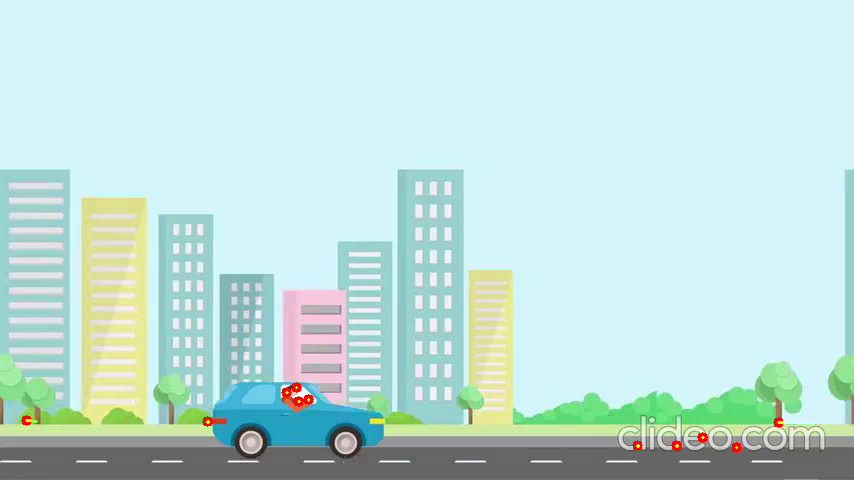

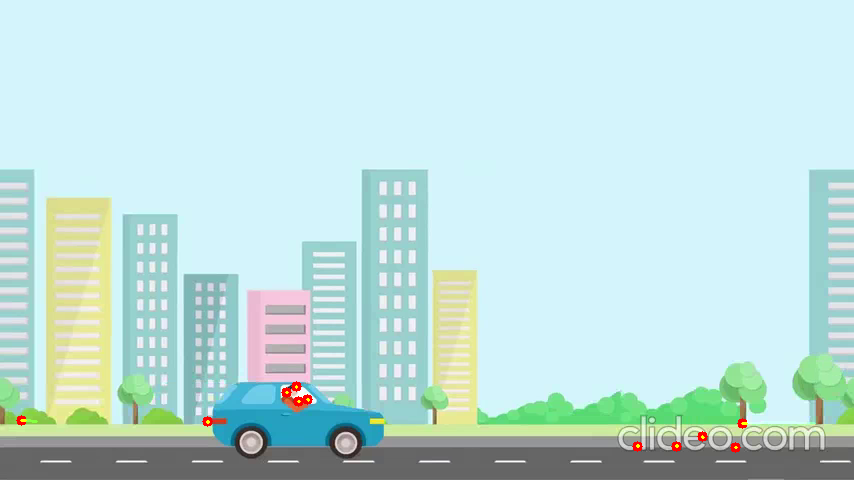

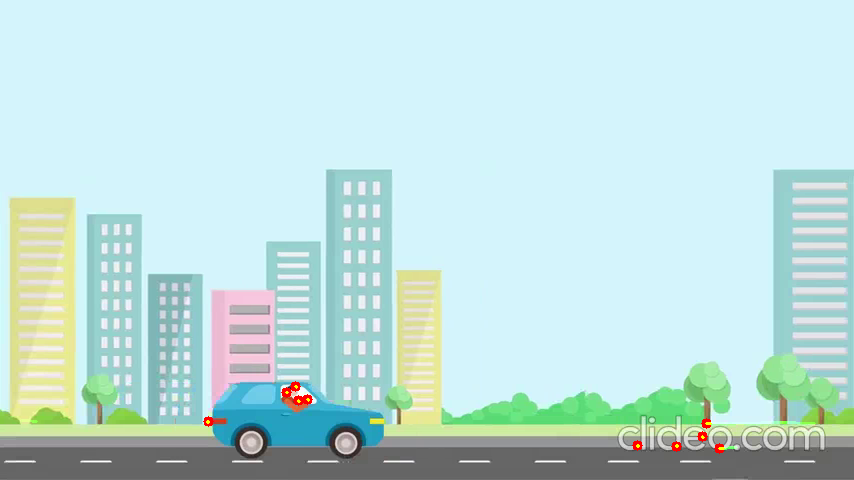

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

# Load the video
cap = cv2.VideoCapture('/content/clideo_editor_024d140c5f4b4d4dbc4bea2d1036e309.mp4')

# Read the first frame and convert it to grayscale
ret, old_frame = cap.read()
if not ret:
    print("Failed to read video")
    cap.release()
    exit()

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Parameters for Shi-Tomasi corner detection (to initialize points to track)
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Detect initial points to track
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing (to visualize the tracks)
mask = np.zeros_like(old_frame)

# Define a maximum number of frames to avoid an infinite loop
max_frames = 8
frame_count = 5

# Process video frames
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None and len(p1[st == 1]) > 0:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

        # Overlay the mask with tracks on the original frame
        output = cv2.add(frame, mask)

        # Display the frame using cv2_imshow
        cv2_imshow(output)

        # Update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        # Increment frame counter
        frame_count += 1

    else:
        print("No points to track. Exiting.")
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


# Exercise 8: Image Stitching (Mosaicing)

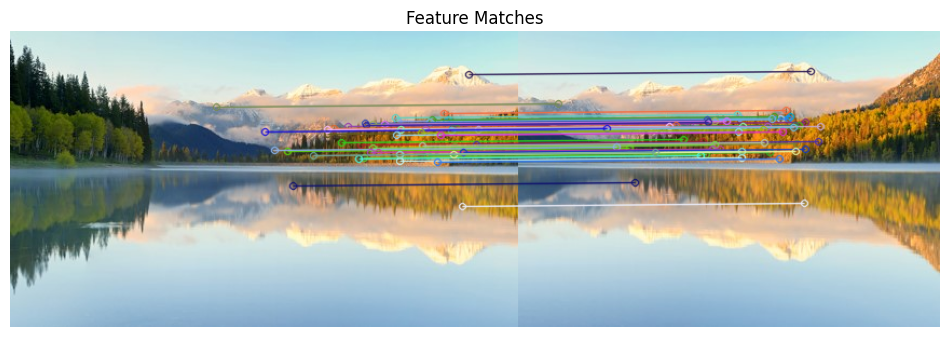

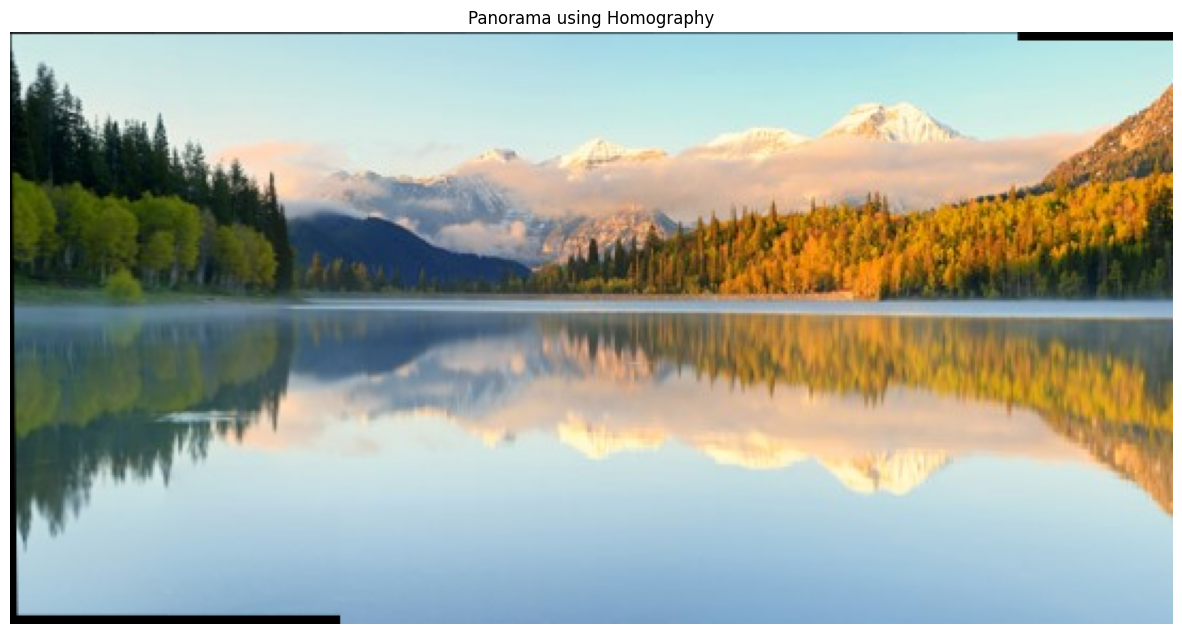

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images to stitch
image1 = cv2.imread('/content/1.jpg')
image2 = cv2.imread('/content/2.jpg')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Step 1: Feature Detection and Matching using ORB
orb = cv2.ORB_create(5000)

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Match features using Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (smallest distances are best matches)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top matches for visualization (optional)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches")
plt.axis("off")
plt.show()

# Step 2: Homography Estimation with RANSAC

# Extract location of good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute homography matrix using RANSAC
homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 3: Image Stitching (Warps the first image to align with the second)

# Get dimensions of both images to create a large canvas for the panorama
height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

# Define the corners of the first image and transform them to find the canvas size
corners_image1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
corners_image1_transformed = cv2.perspectiveTransform(corners_image1, homography_matrix)

# Combine the corners of both images to determine the bounds of the final panorama
all_corners = np.concatenate((corners_image1_transformed, np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Compute the translation to adjust for any negative values (shifting)
translation_dist = [-x_min, -y_min]

# Adjust homography matrix to account for translation
translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
homography_matrix = translation_matrix @ homography_matrix  # Matrix multiplication

# Warp the first image using the homography matrix
canvas_size = (x_max - x_min, y_max - y_min)
warped_image = cv2.warpPerspective(image1, homography_matrix, canvas_size)

# Place the second image onto the warped image canvas
warped_image[translation_dist[1]:height2+translation_dist[1], translation_dist[0]:width2+translation_dist[0]] = image2

# Display the resulting stitched panorama
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title("Panorama using Homography")
plt.axis("off")
plt.show()


# Exercise 9: Image Morphing and Blending

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images
image1 = cv2.imread('/content/1.jpg')
image2 = cv2.imread('/content/2.jpg')

# Resize image2 to match image1's dimensions
height, width = image1.shape[:2]
image2 = cv2.resize(image2, (width, height))

# Ensure both images are in the same color format (e.g., BGR)
if image1.shape[2] != image2.shape[2]:
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR) if len(image2.shape) == 2 else image2

# Display the two images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.axis("off")
plt.show()

# Step 1: Image Morphing (Simple Interpolation)
def morph_images(img1, img2, steps=10):
    """Morph between two images using linear interpolation."""
    for i in range(steps + 1):
        alpha = i / steps
        morphed = cv2.addWeighted(img1, 1 - alpha, img2, alpha, 0)
        plt.imshow(cv2.cvtColor(morphed, cv2.COLOR_BGR2RGB))
        plt.title(f"Step {i + 1}/{steps}")
        plt.axis("off")
        plt.show()

# Morph images in 10 steps
morph_images(image1, image2, steps=10)

# Step 2: Alpha Blending
def alpha_blend(img1, img2, alpha=0.5):
    """Blend two images using simple alpha blending."""
    blended = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)
    return blended

# Display blended image
alpha_blended_image = alpha_blend(image1, image2, alpha=0.5)
plt.imshow(cv2.cvtColor(alpha_blended_image, cv2.COLOR_BGR2RGB))
plt.title("Alpha Blending (alpha=0.5)")
plt.axis("off")
plt.show()

# Step 3: Multi-Band Blending (using Laplacian Pyramids)
def pyramid_blending(img1, img2, levels=6):
    """Blend two images using Laplacian pyramids."""
    # Resize images to the smallest dimension
    img1 = cv2.resize(img1, (min(img1.shape[1], img2.shape[1]), min(img1.shape[0], img2.shape[0])))
    img2 = cv2.resize(img2, (min(img1.shape[1], img2.shape[1]), min(img1.shape[0], img2.shape[0])))

    # Generate Gaussian pyramids for img1 and img2
    gp_img1 = [img1.copy()]
    gp_img2 = [img2.copy()]
    for i in range(levels):
        gp_img1.append(cv2.pyrDown(gp_img1[i]))
        gp_img2.append(cv2.pyrDown(gp_img2[i]))

    # Generate Laplacian pyramids for img1 and img2
    lp_img1 = [gp_img1[levels - 1]]
    lp_img2 = [gp_img2[levels - 1]]
    for i in range(levels - 1, 0, -1):
        # Resize the upsampled image to match the original image size
        upsampled_img1 = cv2.pyrUp(gp_img1[i])
        upsampled_img1 = cv2.resize(upsampled_img1, (gp_img1[i - 1].shape[1], gp_img1[i - 1].shape[0]))

        upsampled_img2 = cv2.pyrUp(gp_img2[i])
        upsampled_img2 = cv2.resize(upsampled_img2, (gp_img2[i - 1].shape[1], gp_img2[i - 1].shape[0]))


        laplacian1 = cv2.subtract(gp_img1[i - 1], upsampled_img1)
        laplacian2 = cv2.subtract(gp_img2[i - 1], upsampled_img2)
        lp_img1.append(laplacian1)
        lp_img2.append(laplacian2)

    # Blend each level's Laplacian
    laplacian_pyramid = []
    for l1, l2 in zip(lp_img1, lp_img2):
        rows, cols, dpt = l1.shape
        blend = np.hstack((l1[:, :cols // 2], l2[:, cols // 2:]))
        laplacian_pyramid.append(blend)

    # Reconstruct the image from blended Laplacian pyramid
    # Reconstruct the image from blended Laplacian pyramid
    blended_image = laplacian_pyramid[0]
    for i in range(1, levels):
        blended_image = cv2.pyrUp(blended_image)
        # Resize blended_image to match laplacian_pyramid[i]'s shape before adding
        blended_image = cv2.resize(blended_image, (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))
        blended_image = cv2.add(blended_image, laplacian_pyramid[i])

    return blended_image

# Apply multi-band blending and display
multi_band_blended_image = pyramid_blending(image1, image2, levels=6)
plt.imshow(cv2.cvtColor(multi_band_blended_image, cv2.COLOR_BGR2RGB))
plt.title("Multi-Band Blending")
plt.axis("off")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Exercise 10: Object Recognition Using SVM and CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
# Define paths and parameters
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'
img_height, img_width = 128, 128  # Resize for VGG16
batch_size = 32

# Set up data generators
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',  # Sparse categorical labels for multi-class
    subset='training'
)

validation_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Load VGG16 model for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Extract features and labels
features, labels = [], []
for inputs, label in train_data:
    features_batch = vgg16.predict(inputs)
    features.append(features_batch)
    labels.append(label)
    if len(features) * batch_size >= train_data.samples:
        break

# Reshape features and labels for SVM
features = np.vstack(features)
features = features.reshape((features.shape[0], -1))  # Flatten features
labels = np.concatenate(labels)

from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train SVM classifier
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

# Evaluate SVM model
y_pred_svm = svm_clf.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred_svm)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_val, y_pred_svm))

# Define a CNN model
cnn_model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # 8 classes for clothing data
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(train_data, epochs=10, validation_data=validation_data)

# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(validation_data)
print("CNN Accuracy:", cnn_accuracy)

print("Comparison of SVM and CNN Performance:")
print(f"SVM Model Accuracy: {svm_accuracy * 100:.2f}%")
print(f"CNN Model Accuracy: {cnn_accuracy * 100:.2f}%")


Found 640 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SVM Accuracy: 0.8046875
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        12
         1.0       0.79    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.1524 - loss: 2.1601 - val_accuracy: 0.3500 - val_loss: 1.8116
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.4094 - loss: 1.6588 - val_accuracy: 0.5250 - val_loss: 1.3938
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.6109 - loss: 1.1615 - val_accuracy: 0.5750 - val_loss: 1.0962
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.7235 - loss: 0.7996 - val_accuracy: 0.6562 - val_loss: 0.9566
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.8280 - loss: 0.4986 - val_accuracy: 0.6812 - val_loss: 0.9822
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9003 - loss: 0.3012 - val_accuracy: 0.6562 - val_loss: 1.1435
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9094 - loss: 0.2211 - val_accuracy: 0.7063 - val_loss: 1.1636
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9820 - loss: 0.1191 - val_accuracy: 0.6938 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


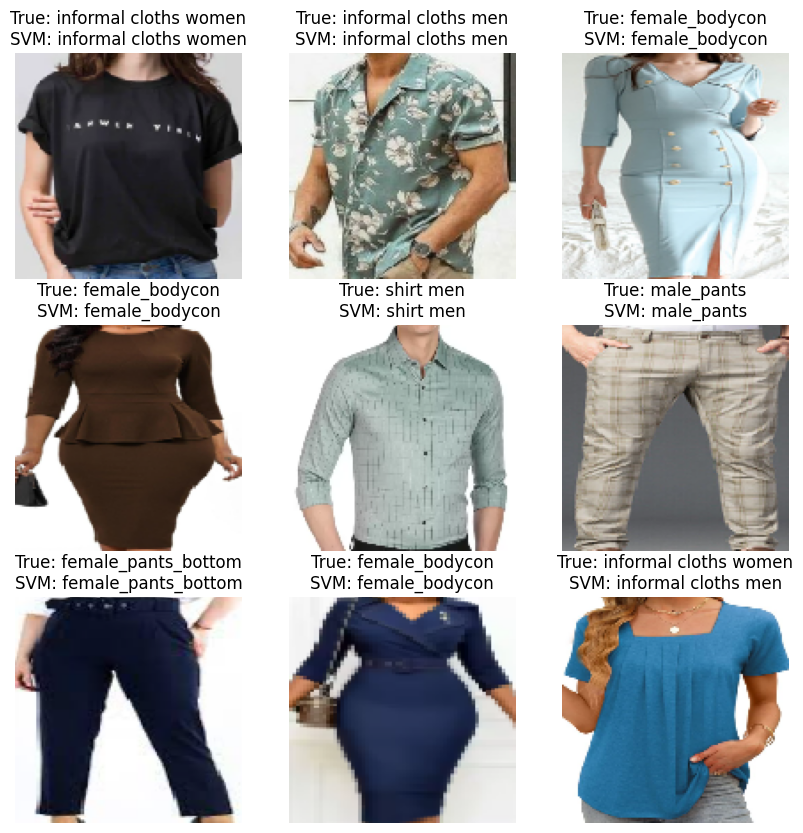

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


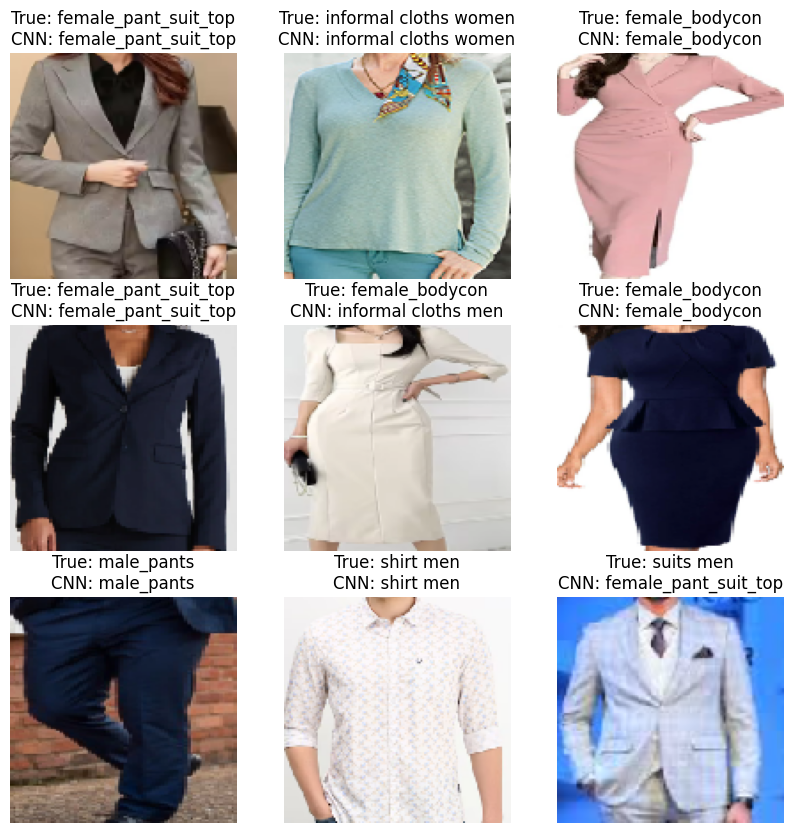

In [2]:
import matplotlib.pyplot as plt

# Function to display images with predictions
def display_predictions(images, true_labels, predicted_labels, label_names, model_name):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Show up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {label_names[int(true_labels[i])]}\n{model_name}: {label_names[int(predicted_labels[i])]}")
        plt.axis("off")
    plt.show()

# Mapping from label indices to class names
label_names = list(train_data.class_indices.keys())

# Display predictions for SVM
svm_features, svm_images, svm_true_labels = [], [], []
for inputs, labels in validation_data:
    features_batch = vgg16.predict(inputs)
    features_batch = features_batch.reshape((features_batch.shape[0], -1))  # Flatten features
    svm_features.append(features_batch)
    svm_images.extend(inputs)  # Store original images for display
    svm_true_labels.extend(labels)
    if len(svm_images) >= 9:  # Collect up to 9 images
        break

# Concatenate features and labels for SVM
svm_features = np.vstack(svm_features)
svm_pred_labels = svm_clf.predict(svm_features)

# Display SVM predictions
display_predictions(svm_images[:9], svm_true_labels[:9], svm_pred_labels[:9], label_names, "SVM")

# Display predictions for CNN
cnn_images, cnn_true_labels, cnn_pred_labels = [], [], []
for i, (inputs, labels) in enumerate(validation_data):
    preds = cnn_model.predict(inputs)
    pred_labels = np.argmax(preds, axis=1)
    cnn_images.extend(inputs)
    cnn_true_labels.extend(labels)
    cnn_pred_labels.extend(pred_labels)
    if len(cnn_images) >= 9:
        break

# Display CNN predictions
display_predictions(cnn_images[:9], cnn_true_labels[:9], cnn_pred_labels[:9], label_names, "CNN")
